# HA Chapter 8: Exponential Smoothing

#| echo : false

#| message : false

#| output : false

## import libraries

In [79]:
#| echo : false
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from scipy.stats import boxcox
from scipy.special import inv_boxcox1p
from statsmodels.tsa.seasonal import seasonal_decompose

In [80]:
# | echo : false
pd.set_option('display.max_columns', 10)
plt.rcParams['figure.figsize'] = (10, 6)

---

## Exercise 8.1

Consider the the number of pigs slaughtered in Victoria, available in the aus_livestock dataset.


In [81]:
#| echo : false
#| warning : false
#| message : false

aus_livestock = pd.read_csv('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/aus_livestock.csv', parse_dates=True, index_col = 'Month')
aus_livestock 

C:\Users\nickc\AppData\Local\Temp\ipykernel_28708\45342766.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  aus_livestock = pd.read_csv('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/aus_livestock.csv', parse_dates=True, index_col = 'Month')


,Unnamed: 0,Animal,State,Count
Month,,,,
1976-07-01,1,"Bulls, bullocks and steers",Australian Capital Territory,2300.0
1976-08-01,2,"Bulls, bullocks and steers",Australian Capital Territory,2100.0
1976-09-01,3,"Bulls, bullocks and steers",Australian Capital Territory,2100.0
1976-10-01,4,"Bulls, bullocks and steers",Australian Capital Territory,1900.0
1976-11-01,5,"Bulls, bullocks and steers",Australian Capital Territory,2100.0
...,...,...,...,...
2018-08-01,29360,Sheep,Western Australia,160600.0
2018-09-01,29361,Sheep,Western Australia,121900.0
2018-10-01,29362,Sheep,Western Australia,134000.0



### Part A

Use the ETS() function to estimate the equivalent model for simple exponential smoothing. Find the optimal values of α and $ℓ_0$, and generate forecasts for the next four months.



In [82]:
# filter data
victorian_pigs = aus_livestock.query('Animal == "Pigs" & State == "Victoria"')[['Count']]

In [83]:
#| warning : false

from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(victorian_pigs, trend = 'additive', seasonal = None).fit()

predictions = model.forecast(steps=4) # predict the next 4 time steps

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [84]:
victorian_pigs.tail()

,Count
Month,
2018-08-01,102500.0
2018-09-01,82600.0
2018-10-01,100700.0
2018-11-01,98500.0
2018-12-01,92300.0


In [85]:
print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Count   No. Observations:                  558
Model:             ExponentialSmoothing   SSE                    49759385612.180
Optimized:                         True   AIC                          10222.807
Trend:                         Additive   BIC                          10240.105
Seasonal:                          None   AICC                         10222.960
Seasonal Periods:                  None   Date:                 Sun, 03 Mar 2024
Box-Cox:                          False   Time:                         18:57:44
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3350000                alpha                 True
smoothing_trend            0.02791

The optimal $\alpha = 0.335$ and $l_0 =  1.0843e+05$. 

Having a lower alpha estimates means that the exponential decay is slower and we can expected that the next 4 forecasts will be close in value. 

The forecasts for the next 4 time steps are below.

In [86]:
print(predictions)

2019-01-01    95532.225056
2019-02-01    95637.681211
2019-03-01    95743.137366
2019-04-01    95848.593521
Freq: MS, dtype: float64



### Part B

Compute a 95% prediction interval for the first forecast using  $\hat{y}±1.96s$ where $s$ is the standard deviation of the residuals. Compare your interval with the interval produced by R

In [87]:
# we need to calc only the first forecast 
residuals_std = model.resid.std()

first_forecast = predictions.iloc[0]

margin_of_error = 1.96 * residuals_std

lower_limit = first_forecast - margin_of_error
upper_limit = first_forecast + margin_of_error

print(f'95% Prediction Interval: ({lower_limit:.2f}, {upper_limit:.2f})')


95% Prediction Interval: (77022.62, 114041.83)


Rcode :

```{r}

```{r}
fc |>
  autoplot(tail(vic_pigs, 5)) +
  geom_line(aes(y = .fitted), col="#D55E00",
            data = augment(fit)) +
  labs(y="% of GDP", title="Victorian Pigs") +
  guides(colour = "none")
```

\` \` \`

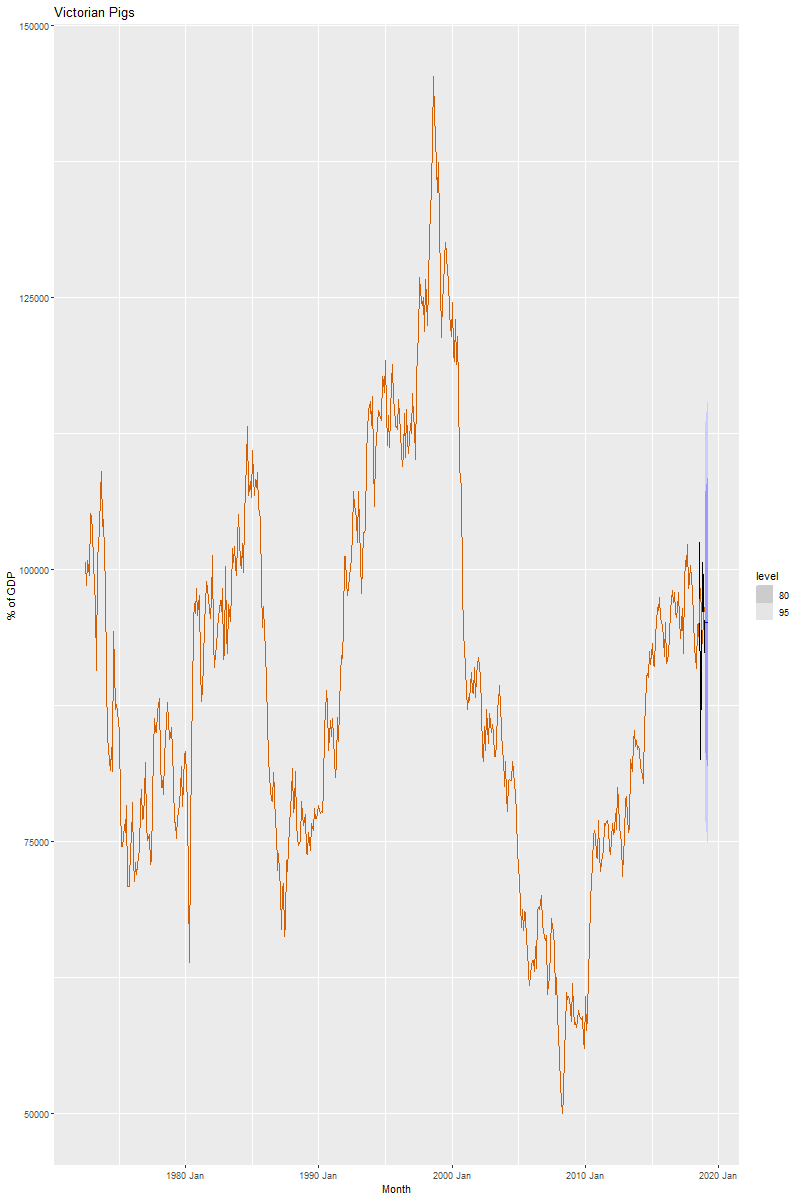

My 95% confidence intervals is narrower compared to the confidence interval produced from the Rcode. We suspect that this may due to different smoothing and leveling estimates.

---

## Exercise 8.5

Data set `global_economy` contains the annual Exports from many countries. Select one country to analyse.

### Part A 

Plot the Exports series and discuss the main features of the data

In [88]:
#|echo : false

global_economy = pd.read_csv("c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/global_economy.csv", parse_dates = ['Year'], index_col = 'Year')


In [89]:
canada_exports = global_economy.query('Country == "Canada"')[['Exports']]

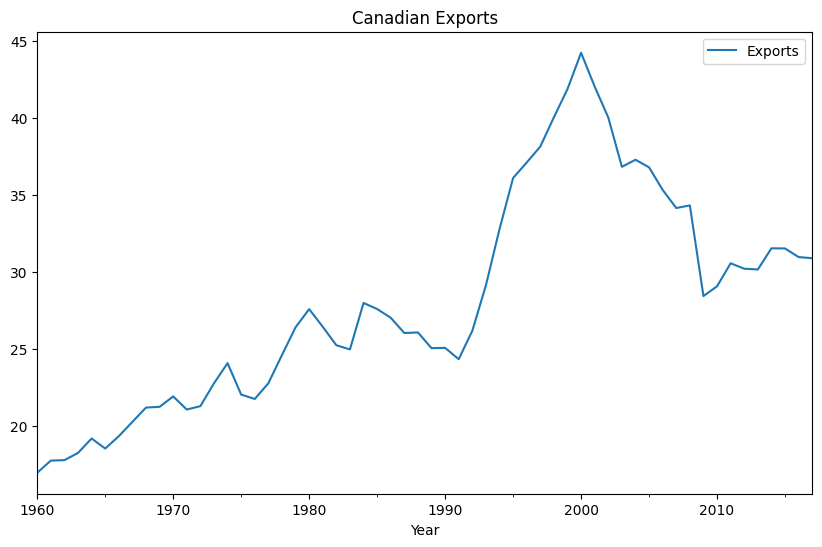

In [90]:
canada_exports.plot()
plt.title('Canadian Exports')
plt.show()

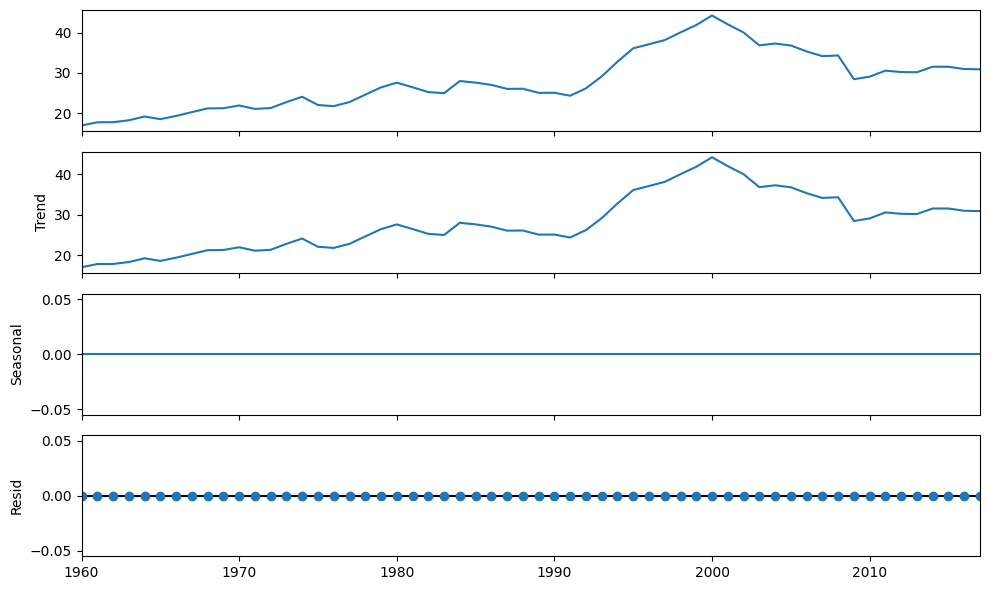

In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(canada_exports, model='additive')
result.plot()
plt.show()

Canada's exports exhibits a overall upward trend from 1960 to 2017, with a notable growth during the 1990s. This trend peaked around the year 2000, followed by a decline until 2010 where it started to stabilize. The time series decomposition confirms the absence of seasonality, demosntrating a straight line seasonal component.

### Part B

Use an ETS(A,N,N) model to forecast the series, and plot the forecasts.


In [92]:
# train test split 
train_data, test_data = canada_exports[0:int(len(canada_exports)*0.8)], canada_exports[int(len(canada_exports)*0.8):]


In [93]:
# ETS(A,N,N) would be trend = 'add' and damped_trend = False
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

ets_model = ETSModel(train_data['Exports'], trend = 'add', damped_trend = False, seasonal = None).fit()

forecast = ets_model.forecast(steps=len(test_data))

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


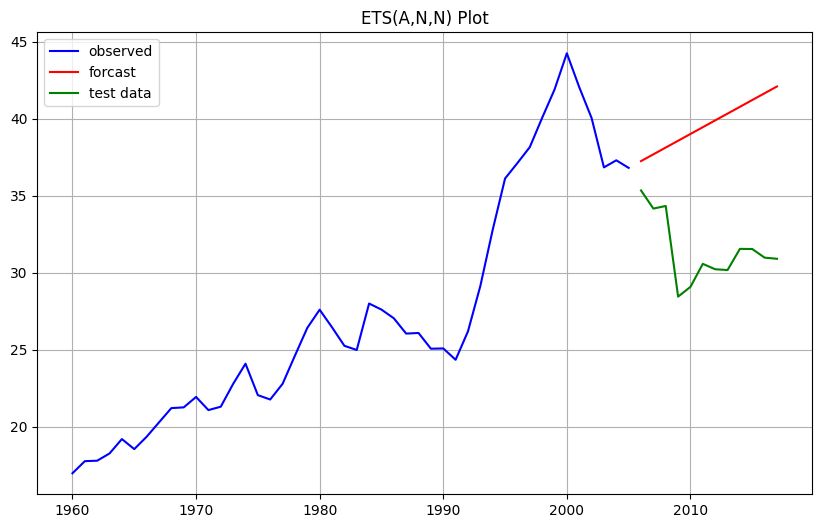

In [94]:

plt.plot(train_data.index, train_data, color = 'blue', label='observed')
plt.plot(forecast.index, forecast, color = 'red', label='forcast')
plt.plot(test_data.index, test_data, color = 'green', label='test data')


plt.legend()
plt.title('ETS(A,N,N) Plot')
plt.grid(True)
plt.show()

### Part C

Compute the RMSE values for the training data.

In [95]:

fitted_values = ets_model.fittedvalues

In [96]:
from sklearn.metrics import mean_squared_error
ann_rmse = mean_squared_error(train_data, fitted_values)

print(f'RMSE: {mean_squared_error(train_data, fitted_values)}')

RMSE: 2.1710919202650967


### Part D

Compare the results to those from an ETS(A,A,N) model. (Remember that the trended model is using one more parameter than the simpler model.) Discuss the merits of the two forecasting methods for this data set.

In [97]:
# for this it is trend ='add' and damped_trend = True

model = ETSModel(train_data['Exports'], trend = 'add', damped_trend=True, seasonal=None).fit()

aan_forecast = model.forecast(steps = len(test_data))

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


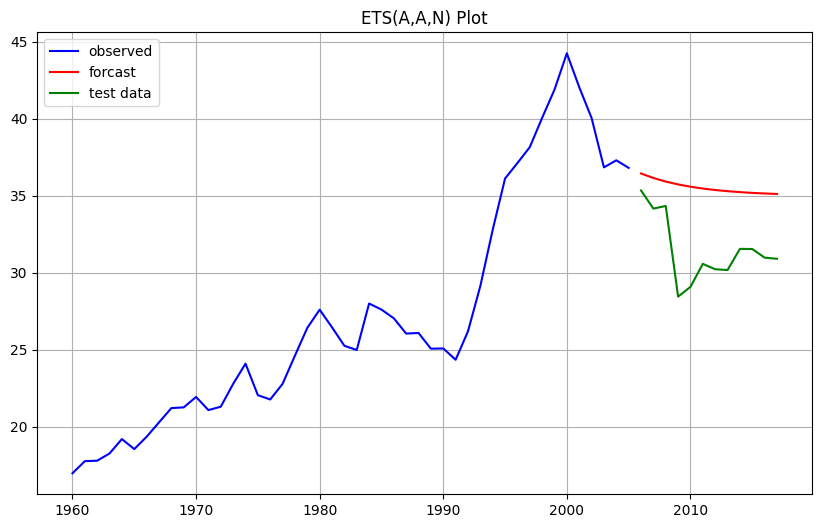

In [98]:
plt.plot(train_data.index, train_data, color = 'blue', label='observed')
plt.plot(aan_forecast.index, aan_forecast, color = 'red', label='forcast')
plt.plot(test_data.index, test_data, color = 'green', label='test data')

plt.legend(loc = 'upper left')
plt.title('ETS(A,A,N) Plot')
plt.grid(True)
plt.show()

In [99]:
fitted_values = model.fittedvalues
aan_rmse = mean_squared_error(train_data, fitted_values)
print(f'RMSE: {mean_squared_error(train_data, fitted_values)}')

RMSE: 1.9496787243825957


### Part E

Compare the forecasts from both methods. Which do you think is best?

Based on the forecasts, we conclude that ETS(A,A,N) provides a better fit for out timeseries. Not only does its capture the observed downward trend of the test set, but this is also supported by its lower RMSE compared to the ETS(A,N,N) model's RMSE. The ETS(A,N,N) model's assumption of the constant trend leads to an incorrent forecast trajectory following the training set. highlinhting the importance of choosing a the correct model.

### Part F

Calculate a 95% prediction interval for the first forecast for each model, using the RMSE values and assuming normal errors. Compare your intervals with those produced using R.

In [100]:
ann_forecast = forecast.iloc[0]
aan_forecast_val  = aan_forecast.iloc[0]

z_value = 1.96 # for 95 percent 

prediction_interval = (ann_forecast - z_value * ann_rmse, ann_forecast + z_value * ann_rmse)
prediction_interval_2 = (aan_forecast_val - z_value * aan_rmse, aan_forecast_val + z_value * aan_rmse)

In [101]:

print('Confidence Interval of the first forecast of the ETS(A,N,N) model: ')
print(prediction_interval)

Confidence Interval of the first forecast of the ETS(A,N,N) model: 
(32.980483846327374, 41.49116417376655)


In [102]:
print('Confidence Interval of the first forecast of the ETS(A,N,N) model: ')
print(prediction_interval_2)

Confidence Interval of the first forecast of the ETS(A,N,N) model: 
(32.61034478739475, 40.25308538697453)


***

## Exercise 8.6

Forecast the Chinese GDP from the `global_economy` data set using an ETS model. Experiment with the various options in the ETS() function to see how much the forecasts change with damped trend, or with a Box-Cox transformation. Try to develop an intuition of what each is doing to the forecasts.

[Hint: use a relatively large value of h when forecasting, so you can clearly see the differences between the various options when plotting the forecasts.]

In [103]:
#| echo : false
global_economy = pd.read_csv('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/global_economy.csv', parse_dates=['Year'], index_col = 'Year')


In [104]:
china_gdp = global_economy.query('Country == "China"')[['GDP']]

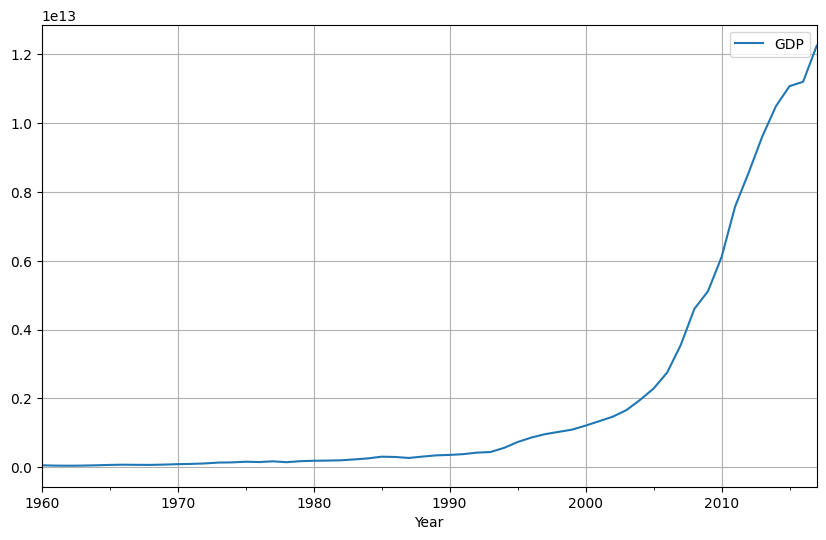

In [105]:
china_gdp.plot()
plt.grid(True)
plt.show()

In [106]:
train_data, test_data = china_gdp[0:int(len(china_gdp)*0.8) +1], china_gdp[int(len(china_gdp)*0.8):]

In [107]:
# base model
model_1 = ETSModel(train_data['GDP'], trend='add', seasonal=None).fit()

forecast_1 = model_1.forecast(steps=len(test_data))


c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [108]:
# with the damped trend 

model_2 = ETSModel(train_data['GDP'], trend = 'add', damped_trend=True, seasonal=None).fit()

forecast_2 = model_2.forecast(steps = len(test_data))

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [109]:
# box-cox transformation
from scipy.stats import boxcox
from scipy.special import inv_boxcox1p

gdp_transformed, lmbda = boxcox(train_data['GDP']) #| type: ignore

train_data['gdp_boxcox'] = gdp_transformed

model_3 = ETSModel(train_data['gdp_boxcox'], trend = 'add', seasonal = None).fit()

forecast_3 = model_3.forecast(steps = len(test_data))
forecast_3 = inv_boxcox1p(forecast_3, lmbda) # undo the tranfromation

C:\Users\nickc\AppData\Local\Temp\ipykernel_28708\3408299051.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['gdp_boxcox'] = gdp_transformed
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [110]:
# log transform with damped

train_data.loc[:, 'log_gdp'] = np.log(train_data['GDP']).copy() 

model_4 = ETSModel(train_data['log_gdp'], trend = 'add', damped_trend= True, seasonal = None).fit()

forecast_4 = model_4.forecast(steps= len(test_data))
forecast_4 = np.exp(forecast_4)

C:\Users\nickc\AppData\Local\Temp\ipykernel_28708\3159823729.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'log_gdp'] = np.log(train_data['GDP']).copy()
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


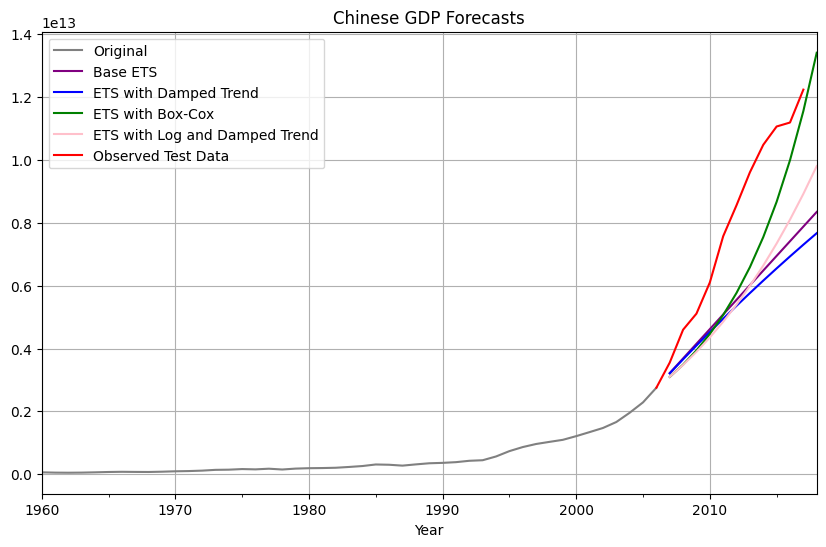

In [111]:
train_data['GDP'].plot(label='Original', color = 'grey')
forecast_1.plot(label='Base ETS', color = 'purple')
forecast_2.plot(label='ETS with Damped Trend', color ='blue')
forecast_3.plot(label='ETS with Box-Cox', color = 'green')
forecast_4.plot(label= 'ETS with Log and Damped Trend', color = 'pink')
test_data['GDP'].plot(label = 'Observed Test Data', color = 'red')
plt.legend()
plt.title('Chinese GDP Forecasts')
plt.grid(True)
plt.show()

The base model with simple exponential smoothing captures the general upward trend of China's GDP. However, as the base model it might not capture the growth rate of the data since the appears to be linear. 
The dampening factor smooths out the trend.  This introduces the intuition that the explosive growth rate observed in the past might slow down in the future. The forecast reflects a less steep trajectory.
The Box-Cox transformation often helps when the pattern of increase in a time series changes over time. In this case, since it fits the test data closely, the intuition is that Chinese GDP might have a pattern of increasingly rapid growth that the standard ETS model wasn't fully capturing.
The log transformation tends to scale down large values. In combination with dampening, this model intuitively suggests a very conservative forecast but knows that growth exists, but will progress much slower than any of the other models project.


---

## Exercise 8.7

Find an ETS model for the Gas data from `aus_production` and forecast the next few years. Why is multiplicative seasonality necessary here? Experiment with making the trend damped. Does it improve the forecasts?

In [112]:
#| echo: false
#| output : false
#| warning : false
aus_production = pd.read_csv('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/aus_production.csv', parse_dates=['Quarter'], index_col='Quarter')

C:\Users\nickc\AppData\Local\Temp\ipykernel_28708\3715506214.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  aus_production = pd.read_csv('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/aus_production.csv', parse_dates=['Quarter'], index_col='Quarter')


In [113]:
aus_gas = aus_production[['Gas']]

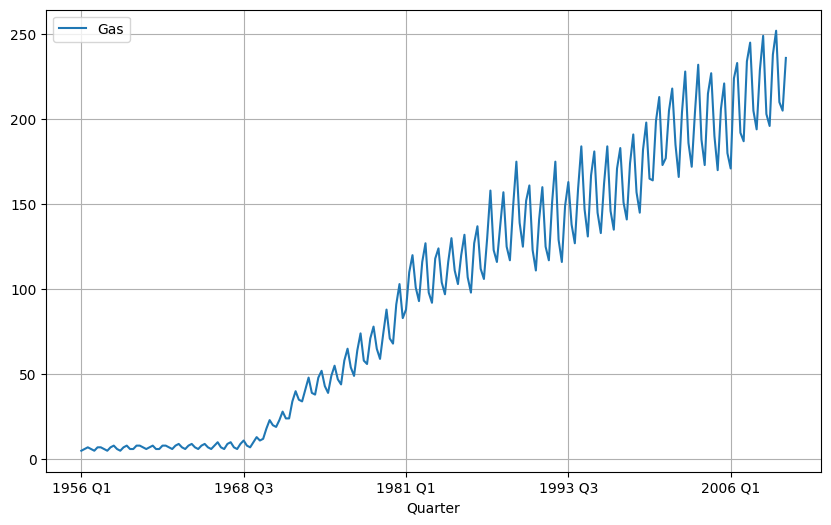

In [114]:
aus_gas.plot()
plt.grid(True)
plt.show()

The Gas production data displays an increasing variance pattern over time. This means that the magnitude of the fluctuations and the impact of the trend component likely scale with the underlying production level. Therefore, a multiplicative ETS model is expected to better capture this behavior and generate more reliable forecasts.

In [115]:
train_data, test_data = aus_gas[0:int(len(aus_gas)*0.8) +1], aus_gas[int(len(aus_gas)*0.8):]

In [116]:
# base model
model = ETSModel(train_data['Gas'], trend = 'add').fit()

forecast_base = model.forecast(steps = len(test_data))

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an 

In [117]:
#  change seasonal to multiplicative
model_mul = ETSModel(train_data['Gas'], trend = 'add', seasonal = 'mul', seasonal_periods = 4).fit()

forecast_mul = model_mul.forecast(steps = len(test_data))

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an 

In [118]:
model_damped = ETSModel(train_data['Gas'], trend = 'add', damped_trend=True, seasonal = 'mul', seasonal_periods = 4).fit()

forecast_damped = model_damped.forecast(steps = len(test_data))

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an 

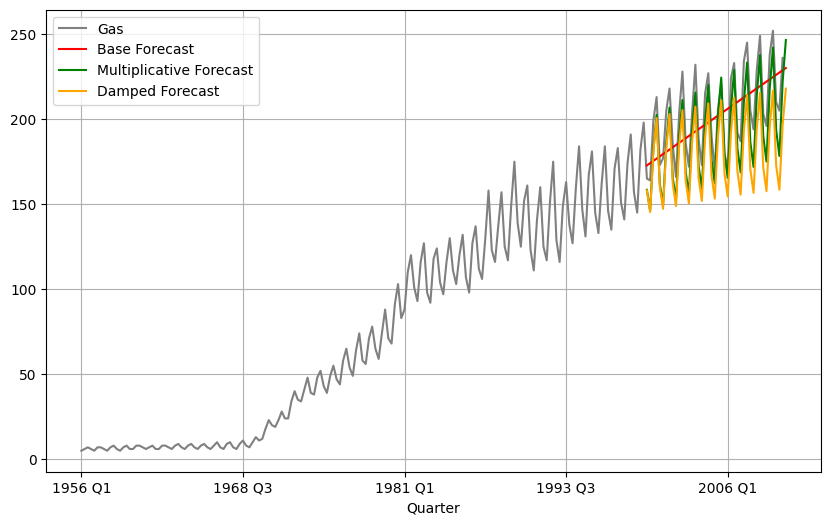

In [119]:
aus_gas.plot(label='Observed Data', color = 'grey')
forecast_base.plot(label = 'Base Forecast', color = 'red')
forecast_mul.plot(label = 'Multiplicative Forecast', color = 'green')
forecast_damped.plot(label = 'Damped Forecast', color = 'orange')

plt.legend()
plt.grid(True)
plt.show()

The damped trend into the ETS model results in a more conservative trend forecast, suggesting a potential slowdown in the growth rate compared to the basic ETS model. While the multiplicative seasonal ETS model appears to align more closely with the observed data patterns than the damped forecast.Thus, indicates that the variance in the time series might increase along with the overall level, making the multiplicative seasonality model a better fit.

---

## Exercise 8.8

Recall your retail time series data (from Exercise 7 in Section 2.10).

In [120]:
#| echo : false
aus_retail = pd.read_csv('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/aus_retail.csv', parse_dates=['Month'], index_col='Month')

C:\Users\nickc\AppData\Local\Temp\ipykernel_28708\3632377730.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  aus_retail = pd.read_csv('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/aus_retail.csv', parse_dates=['Month'], index_col='Month')


In [121]:
aus_retail.State.unique()

array(['Australian Capital Territory', 'New South Wales',
       'Northern Territory', 'Queensland', 'South Australia', 'Tasmania',
       'Victoria', 'Western Australia'], dtype=object)

In [122]:
clothing_retail = aus_retail.query('Industry == "Clothing retailing" & State == "Australian Capital Territory"')[['Turnover']]

### Part A

Why is multiplicative seasonality necessary for this series?

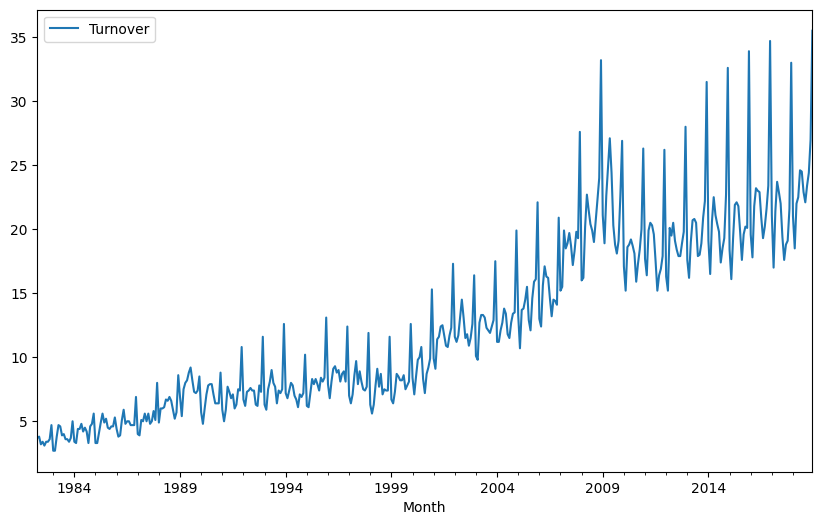

In [123]:
clothing_retail.plot()
plt.show()

In [124]:
train, test= clothing_retail[0:int(len(clothing_retail)*0.8) +1], clothing_retail[int(len(clothing_retail)*0.8):]

### Part B

Apply Holt-Winters’ multiplicative method to the data. Experiment with making the trend damped.

In [125]:
model= ETSModel(train['Turnover'], trend='add', seasonal='mul', damped_trend=False).fit()

forecast= model.forecast(steps = len(test))

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [126]:
model_damp = ETSModel(train['Turnover'], trend='add', seasonal='mul', damped_trend=True).fit()

forecast_damp = model_damp.forecast(steps = len(test))

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


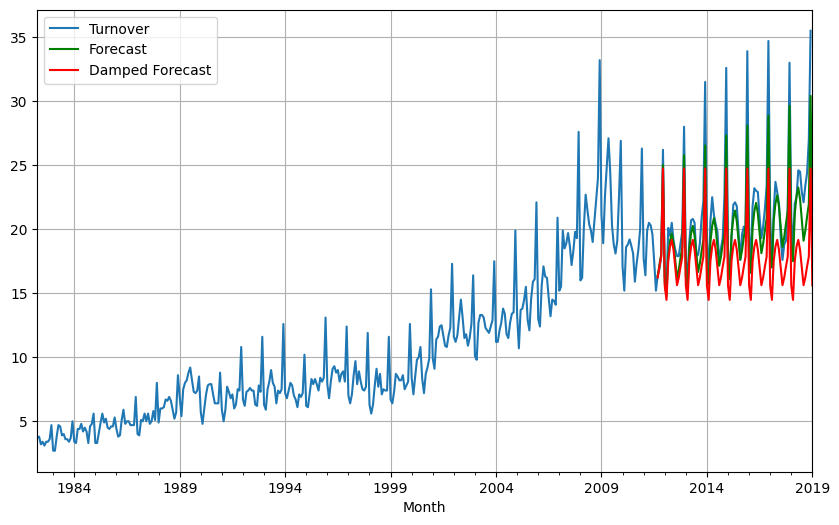

In [127]:
clothing_retail.plot(label = 'Observed')
forecast.plot(label = 'Forecast', color = 'green')
forecast_damp.plot(label = 'Damped Forecast', color = 'red')

plt.legend()
plt.grid(True)
plt.show()

### Part C

Compare the RMSE of the one-step forecasts from the two methods. Which do you prefer?

In [128]:
from sklearn.metrics import mean_squared_error


rmse = np.sqrt(mean_squared_error(test['Turnover'], forecast))
rmse_damp = np.sqrt(mean_squared_error(test['Turnover'], forecast_damp))

print("RMSE (Multiplicative ETS):", rmse)
print("RMSE (Damped Multiplicative ETS):", rmse_damp)

RMSE (Multiplicative ETS): 5.032452417615934
RMSE (Damped Multiplicative ETS): 6.015841153098568


### Part D

Check that the residuals from the best method look like white noise.

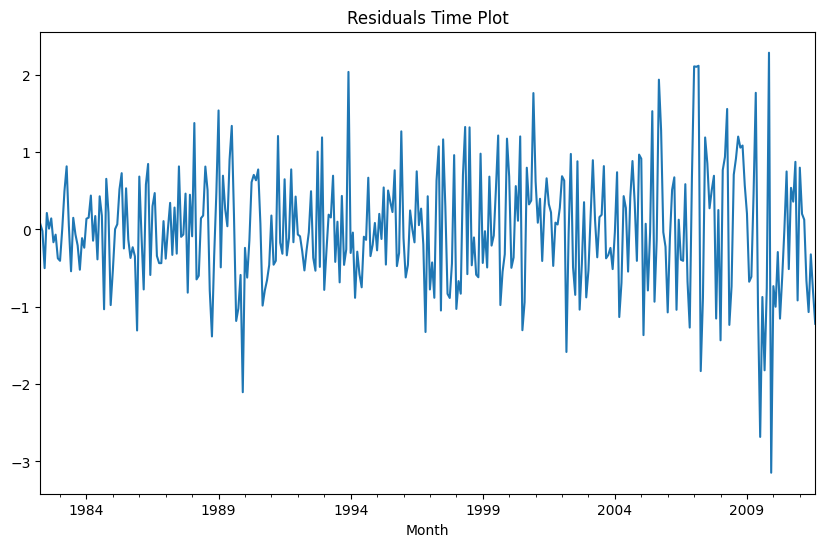

In [129]:
residuals = model.resid
residuals.plot()
plt.title('Residuals Time Plot')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

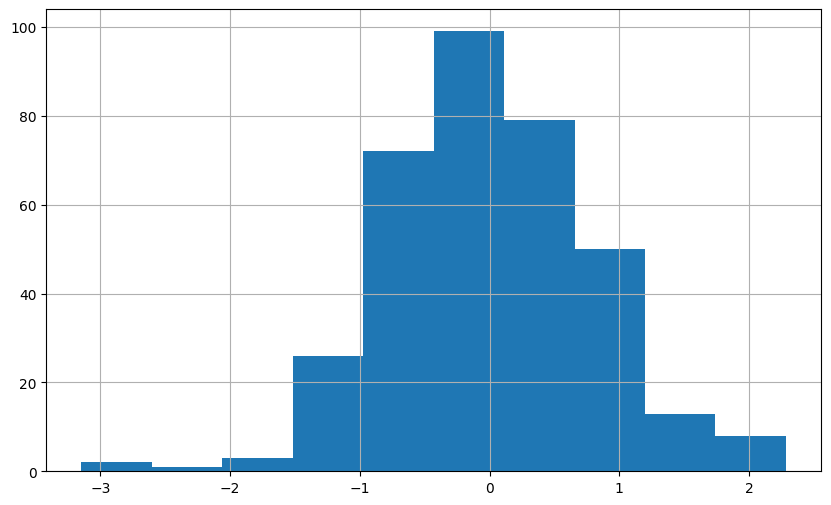

In [130]:
residuals.hist()
plt.show

Residuals exhibits no clear patterns and appears to be randomly scatterred around zero.

In [131]:
print(model.summary())

                                 ETS Results                                  
Dep. Variable:               Turnover   No. Observations:                  353
Model:                       ETS(AAM)   Log Likelihood                -406.420
Date:                Sun, 03 Mar 2024   AIC                            848.840
Time:                        18:57:51   BIC                            918.437
Sample:                    04-01-1982   HQIC                           876.533
                         - 08-01-2011   Scale                            0.586
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6078      0.069      8.747      0.000       0.472       0.744
smoothing_trend      6.078e-05        nan        nan        nan         nan         nan
smoothing_season

The Ljung-Box indicates that the residuals are uncorrelated and Jarque-Bera test rejects the null where the residuals are normality distributed. 

### Part E

Now find the test set RMSE, while training the model to the end of 2010. Can you beat the seasonal naïve approach from Exercise 7 in Section 5.11?

In [132]:
train_2010 = clothing_retail.loc[:'2010']  
model_2010 = ETSModel(train_2010['Turnover'], trend='add', seasonal='mul', damped_trend=True).fit() 

forecast_2010 = model_2010.forecast(steps=len(test)) 

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [133]:
test_rmse = np.sqrt(mean_squared_error(test['Turnover'], forecast_2010))
print("Test Set RMSE (ETS Model):", test_rmse)

Test Set RMSE (ETS Model): 5.003789852798558


---

## Exercise 8.9

For the same retail data, try an STL decomposition applied to the Box-Cox transformed series, followed by ETS on the seasonally adjusted data. How does that compare with your best previous forecasts on the test set?

In [134]:
turnover_boxcox, lmbda = boxcox(train['Turnover'])

train['Turnover_boxcox'] = turnover_boxcox

C:\Users\nickc\AppData\Local\Temp\ipykernel_28708\381446324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Turnover_boxcox'] = turnover_boxcox


In [135]:
stl = seasonal_decompose(train['Turnover_boxcox'], model='mupltiplicative', period=12) 

In [136]:
stl.resid.isna().sum()

12

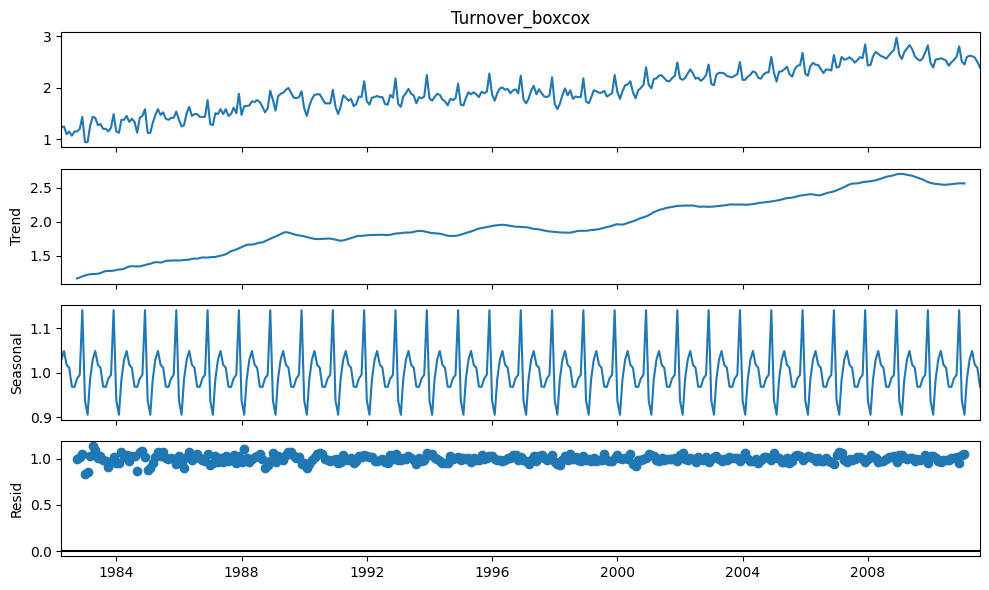

In [137]:
stl.plot()
plt.show()

In [138]:
test_decomposed = seasonal_decompose(train['Turnover_boxcox'], model='additive', period=12)
test_resid = test_decomposed.resid.dropna()

In [139]:
model_ets = ExponentialSmoothing(stl.resid.dropna() + 0.001, trend='add', seasonal='mul', seasonal_periods=12).fit()

forecast= model_ets.forecast(steps=len(test_resid))

forecast = inv_boxcox1p(forecast, lmbda)

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [140]:
test_rmse = np.sqrt(mean_squared_error(test_resid, forecast))
print("Test Set RMSE (ETS Model):", test_rmse)

Test Set RMSE (ETS Model): 1.8695669650523843
